
# Model Error Analysis (Fixed v2: with Train‑based Imputation)

This version additionally **imputes missing values from the TRAIN split** (median for numeric, mode for categoricals) so pipelines that don't include imputers still work. It also keeps the previous fixes: robust path resolution, model loading from file/dir, engineered feature backfills, and alignment with the pipeline’s expected columns.


In [ ]:

# 0) Imports & setup
import os, json, pathlib, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import NotFittedError
from sklearn.inspection import permutation_importance
from dotenv import load_dotenv
import joblib

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (7,4)
RANDOM_SEED = 42

load_dotenv()

DATA_PATH = os.getenv("DATA_PATH")
MODEL_OUTPUT_PATH = os.getenv("MODEL_OUTPUT_PATH")
REPORT_DIR = os.getenv("REPORT_DIR", "reports")

def resolve_path(p):
    if not p:
        return None
    from pathlib import Path
    p = os.path.expandvars(os.path.expanduser(p))
    p = Path(p)
    if p.exists():
        return p
    rel = Path.cwd() / p
    return rel if rel.exists() else p

from pathlib import Path
print("CWD:", Path.cwd())
print("DATA_PATH (raw):", DATA_PATH)
print("MODEL_OUTPUT_PATH (raw):", MODEL_OUTPUT_PATH)

DATA_PATH = resolve_path(DATA_PATH)
MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
assert DATA_PATH and Path(DATA_PATH).exists(), f"DATA_PATH not found: {DATA_PATH}"
assert MODEL_OUTPUT_PATH and Path(MODEL_OUTPUT_PATH).exists(), f"MODEL_OUTPUT_PATH not found: {MODEL_OUTPUT_PATH}"

ART_DIR = Path(REPORT_DIR) / "artifacts"
FIG_DIR = Path(REPORT_DIR) / "figs"
ART_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

CWD: c:\Users\rafae\OneDrive\Documents\Assement
DATA_PATH (raw): Food_Delivery_Times.csv
MODEL_OUTPUT_PATH (raw): C:\Users\rafae\OneDrive\Documents\Assement\models\best_model.joblib
Resolved DATA_PATH: Food_Delivery_Times.csv
Resolved MODEL_OUTPUT_PATH: C:\Users\rafae\OneDrive\Documents\Assement\models\best_model.joblib
Report dirs: reports\artifacts reports\figs


In [26]:

# 1) Load data
df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)
df.head(3)

Data shape: (1000, 9)


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59


In [27]:

# 2) Load model (file or directory). If directory, prefer best_model.joblib, else first .joblib.
from pathlib import Path

def load_model_from_path(p):
    p = Path(p)
    if p.is_dir():
        best = p / "best_model.joblib"
        if best.exists():
            print("Loading model from:", best)
            return joblib.load(best), best
        cands = list(p.glob("*.joblib"))
        assert cands, f"No .joblib files in directory: {p}"
        print("Loading model from:", cands[0])
        return joblib.load(cands[0]), cands[0]
    else:
        print("Loading model from:", p)
        return joblib.load(p), p

model, model_path = load_model_from_path(MODEL_OUTPUT_PATH)

preprocessor = None
is_pipeline = isinstance(model, Pipeline)
if is_pipeline:
    for _, step in model.named_steps.items():
        if isinstance(step, ColumnTransformer):
            preprocessor = step
            break

print("Loaded:", type(model).__name__, "| Pipeline:", is_pipeline, "| Has ColumnTransformer:", preprocessor is not None)

Loading model from: C:\Users\rafae\OneDrive\Documents\Assement\models\best_model.joblib
Loaded: Pipeline | Pipeline: True | Has ColumnTransformer: True


In [28]:

# 3) Pipeline expected columns + engineered backfills
def pipeline_expected_columns(m):
    if not isinstance(m, Pipeline):
        return []
    ct = None
    for _, step in m.named_steps.items():
        if isinstance(step, ColumnTransformer):
            ct = step
            break
    if ct is None:
        return []
    cols = []
    for _, _, cols_spec in ct.transformers:
        if cols_spec == 'drop' or cols_spec == 'passthrough':
            continue
        if isinstance(cols_spec, list):
            cols.extend(cols_spec)
    # dedupe preserving order
    seen, ordered = set(), []
    for c in cols:
        if c not in seen:
            ordered.append(c); seen.add(c)
    return ordered

def ensure_engineered_features(df):
    df = df.copy()
    # Distance_Category
    if "Distance_Category" not in df.columns and "Distance_km" in df.columns:
        df["Distance_Category"] = pd.cut(
            df["Distance_km"],
            bins=[-np.inf, 2, 5, 8, 12, np.inf],
            labels=["0-2","2-5","5-8","8-12","12+"],
            right=True
        )
    # Is_Rush_Hour
    if "Is_Rush_Hour" not in df.columns:
        if "Time_of_Day" in df.columns:
            rush_labels = {"Morning", "Evening"}  # adjust if training used different labels
            df["Is_Rush_Hour"] = df["Time_of_Day"].astype(str).isin(rush_labels).astype(int)
        elif "order_placed_at" in df.columns:
            hours = pd.to_datetime(df["order_placed_at"], errors="coerce").dt.hour
            df["Is_Rush_Hour"] = (
                hours.between(7, 9) | hours.between(17, 20)
            ).fillna(False).astype(int)
        else:
            df["Is_Rush_Hour"] = 0
    return df

expected_cols = pipeline_expected_columns(model)
print("Pipeline expects:", expected_cols if expected_cols else "(artifact did not expose expected columns)")

df = ensure_engineered_features(df)

TARGET = "Delivery_Time_min"
if expected_cols:
    missing_now = set(expected_cols) - set(df.columns)
    if missing_now:
        raise ValueError(f"Missing columns after backfill: {missing_now}. Mirror your train.py feature logic here.")
    X = df[expected_cols].copy()
else:
    base_cols = ["Weather","Traffic_Level","Time_of_Day","Vehicle_Type",
                 "Distance_km","Preparation_Time_min","Courier_Experience_yrs",
                 "Distance_Category","Is_Rush_Hour"]
    keep = [c for c in base_cols if c in df.columns]
    X = df[keep].copy()

y = df[TARGET].copy()
print("X columns used:", list(X.columns))

Pipeline expects: ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Distance_Category', 'Is_Rush_Hour']
X columns used: ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs', 'Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Distance_Category', 'Is_Rush_Hour']


In [29]:

# 4) Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_tr.shape, X_te.shape

((800, 9), (200, 9))

In [30]:

# 5) Train-based imputation (median for numeric, mode for categoricals) to remove NaNs
def impute_like_train(Xtr, Xte):
    Xtr = Xtr.copy(); Xte = Xte.copy()
    num_cols = Xtr.select_dtypes(include=["number"]).columns
    cat_cols = [c for c in Xtr.columns if c not in num_cols]

    # numeric median from TRAIN
    num_meds = Xtr[num_cols].median(numeric_only=True)
    Xtr[num_cols] = Xtr[num_cols].fillna(num_meds)
    Xte[num_cols] = Xte[num_cols].fillna(num_meds)

    # categorical mode from TRAIN
    for c in cat_cols:
        mode = Xtr[c].mode(dropna=True)
        fillv = mode.iloc[0] if not mode.empty else "Unknown"
        Xtr[c] = Xtr[c].fillna(fillv)
        Xte[c] = Xte[c].fillna(fillv)

    return Xtr, Xte

X_tr, X_te = impute_like_train(X_tr, X_te)

# quick sanity
assert not pd.isna(X_tr).any().any(), "NaNs remain in X_tr"
assert not pd.isna(X_te).any().any(), "NaNs remain in X_te"
"Imputation done" 

'Imputation done'

In [31]:

# 6) Predict on test set
def predict_with(model, pre, X):
    if isinstance(model, Pipeline):
        return model.predict(X)
    elif pre is not None and hasattr(pre, "transform"):
        Xp = pre.transform(X)
        return model.predict(Xp)
    else:
        return model.predict(X)

y_pred = predict_with(model, preprocessor, X_te)
len(y_pred), y_te.shape

(200, (200,))

In [32]:
# 7) Metrics & save predictions
mse = mean_squared_error(y_te, y_pred)  # compatibility across sklearn versions
rmse = float(np.sqrt(mse))
mae  = mean_absolute_error(y_te, y_pred)
r2   = r2_score(y_te, y_pred)

metrics = {"rmse": rmse, "mae": float(mae), "r2": float(r2)}
print("Metrics:", metrics)

with open(ART_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

pred_df = pd.DataFrame({"y_true": y_te.values, "y_pred": y_pred})
pred_df["residual"] = pred_df["y_true"] - pred_df["y_pred"]
pred_df.to_csv(ART_DIR / "test_predictions.csv", index=False)
pred_df.head()


Metrics: {'rmse': 8.866624863749731, 'mae': 5.8960213480542585, 'r2': 0.8246044061170907}


,y_true,y_pred,residual
0,32,32.253327,-0.253327
1,68,57.461985,10.538015
2,39,43.218213,-4.218213
3,44,40.942601,3.057399
4,85,77.333961,7.666039


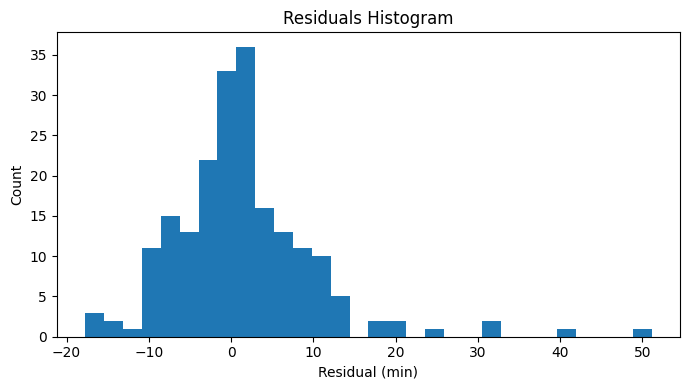

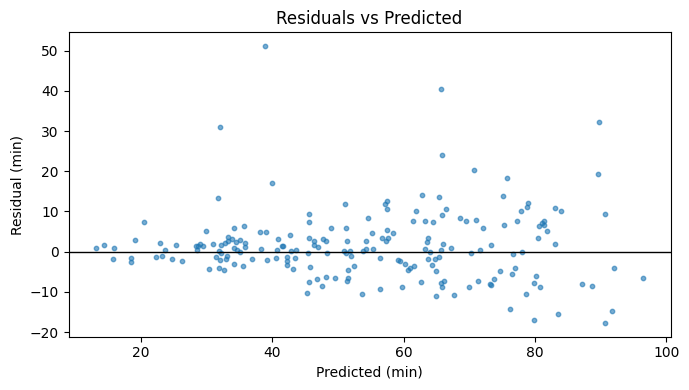

In [33]:

# 8) Diagnostic plots
plt.figure()
plt.hist(pred_df["residual"], bins=30)
plt.title("Residuals Histogram")
plt.xlabel("Residual (min)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "residuals_hist.png", dpi=120)
plt.show()

plt.figure()
plt.scatter(pred_df["y_pred"], pred_df["residual"], s=10, alpha=0.6)
plt.axhline(0, color="k", lw=1)
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted (min)")
plt.ylabel("Residual (min)")
plt.tight_layout()
plt.savefig(FIG_DIR / "residuals_vs_pred.png", dpi=120)
plt.show()

In [34]:

# 9) Slice error analysis
slices = X_te.copy()
slices["y_true"] = y_te.values
slices["y_pred"] = y_pred
slices["residual"] = slices["y_true"] - slices["y_pred"]

if "Distance_km" in slices.columns:
    slices["dist_bin"] = pd.cut(slices["Distance_km"], bins=[0,2,5,8,12, np.inf], labels=["0-2","2-5","5-8","8-12","12+"])

def err_table(by):
    g = slices.groupby(by)["residual"].agg(
        n="count",
        mae=lambda s: np.mean(np.abs(s)),
        rmse=lambda s: np.sqrt(np.mean(s**2)),
        mean_err="mean"
    ).sort_values("rmse", ascending=False)
    return g

if "Weather" in slices.columns:
    slice_weather = err_table("Weather"); slice_weather.to_csv(ART_DIR / "slice_weather.csv"); display(slice_weather)
if "Traffic_Level" in slices.columns:
    slice_traffic = err_table("Traffic_Level"); slice_traffic.to_csv(ART_DIR / "slice_traffic.csv"); display(slice_traffic)
if "dist_bin" in slices.columns:
    slice_dist = err_table("dist_bin"); slice_dist.to_csv(ART_DIR / "slice_distance.csv"); display(slice_dist)

,n,mae,rmse,mean_err
Weather,,,,
Foggy,21,10.000448,16.677755,6.006927
Windy,16,6.069052,9.645879,2.310394
Rainy,40,5.881701,8.068053,1.623271
Snowy,20,6.181049,7.683836,0.192596
Clear,103,4.982534,6.689403,0.607655


,n,mae,rmse,mean_err
Traffic_Level,,,,
High,38,8.194464,13.690474,3.243145
Low,83,5.944677,8.036841,1.702091
Medium,79,4.739323,6.404176,0.379367


,n,mae,rmse,mean_err
dist_bin,,,,
2-5,35,4.350245,10.370076,2.646774
12+,77,8.080871,9.989760,0.975233
5-8,33,4.216706,8.135779,2.242401
8-12,39,6.033824,7.140727,0.899986
0-2,16,1.890511,2.529982,1.103397


In [35]:

# 10) Permutation importance
if isinstance(model, Pipeline):
    X_eval = X_te
else:
    X_eval = preprocessor.transform(X_te) if (preprocessor is not None and hasattr(preprocessor, "transform")) else X_te

perm = permutation_importance(model, X_eval, y_te, n_repeats=10, random_state=RANDOM_SEED)

feature_names = list(getattr(X_te, "columns", [f"f{i}" for i in range(len(perm.importances_mean))]))
fi = pd.DataFrame({"feature": feature_names[:len(perm.importances_mean)],
                   "importance": perm.importances_mean[:len(feature_names)]}).sort_values("importance", ascending=False)
fi.to_csv(ART_DIR / "feature_importance.csv", index=False)
display(fi.head(15))

,feature,importance
0,Distance_km,1.242459
1,Preparation_Time_min,0.204096
4,Traffic_Level,0.099502
3,Weather,0.058746
2,Courier_Experience_yrs,0.015049
6,Vehicle_Type,0.002145
8,Is_Rush_Hour,0.000414
7,Distance_Category,0.000000
5,Time_of_Day,-0.000763


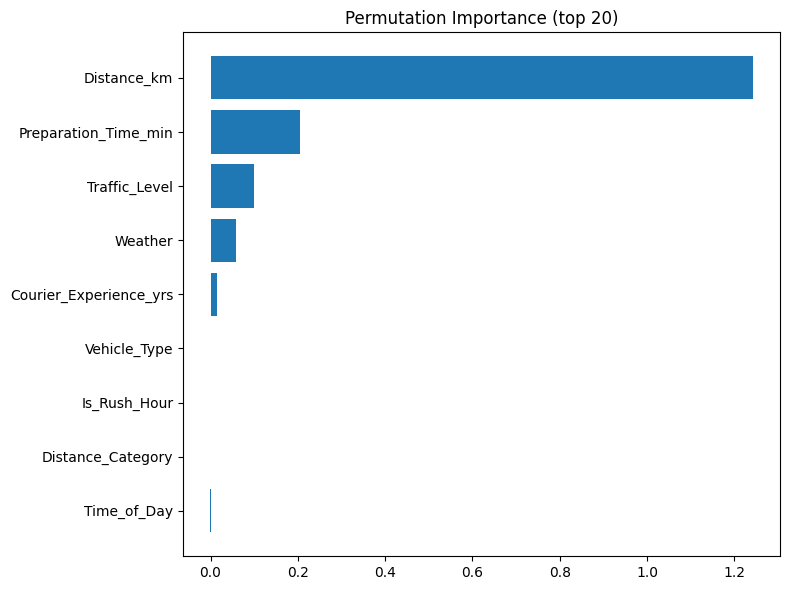

In [36]:

# 11) Plot top-20 permutation importance
top = fi.head(20)[::-1]
plt.figure(figsize=(8,6))
plt.barh(top["feature"], top["importance"])
plt.title("Permutation Importance (top 20)")
plt.tight_layout()
plt.savefig(FIG_DIR / "feature_importance.png", dpi=120)
plt.show()